<h1>Fitting a straight line with errors in x and y in Python using Stan</h1>

<h3>Importing things we will need</h3>

In [1]:
import numpy as np               # numpy to deal with arrays and vectorise stuff
import matplotlib.pyplot as plt  # matplotlib for plotting
import pystan                    # pystan is the interface between Python and Stan
import stan_utility              # read in the utility file to handle Stan models
import pickle                    # pickle saves files for re-use later
import corner                    # makes corner plots of distributions
#plt.style.use('thomas')

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


<h3>Goal:<br>
    Given a data set of $x$ and $y$ values with uncertainties $\sigma_{x}$ and $\sigma_{y}$,<br>
    find the parameters $a$ and $b$ that describe the data through the model<br>
    of the form $y = a + b \cdot x$.</h3>

<h3>Step 1:<br>
    Create test data</h3>

<h5>True parameters</h5>

In [2]:
a = 10 # y-intercept
b = 2 # slope

<h5>Create a number $N_{obs}$ of $x$-values of data set, $x_i$, where $i=0 \dots N_{obs}-1$</h5>

In [3]:
N_obs    = 10                       # number of data points
x_latent = np.random.rand(N_obs)*10 # N_obs x-values between 0 and 10, un-equally spaced

<h5>True data points, $y_i = f(x_i) = a + b \cdot \hat{x}_i$</h5>

In [4]:
y_true   = a + b*x_latent

<h5>Each $y_i$ is obscured by the measurement process, i.e. introduces an uncertainty $\sigma_{y,i}$ such that<br>
    $y_i \sim \mathscr{N}(a + b \cdot \hat{x}_i,\sigma_{y,i})$,<br>
    which defines the data points as scattered normally around $y_i = a + b \cdot \hat{x}_i$ with width $\sigma_{y,i}$.<br><br>
    Here, $\hat{x}_i$ is the latent (true) value that we find from the observed $x_i$ and its measurement uncertainty $\sigma_{x,i}$ so that $\hat{x}_i \sim \mathscr{N}(x_i,\sigma_{x,i})$.<br><br>
    Thus, the total model (data generating process) is describes as:<br>
    $y = \mathscr{N}(a + b \cdot \hat{x},\sigma_y)$<br>
    $\hat{x} = \mathscr{N}(x,\sigma_x)$.<br><br>
    Note that in a normal fit with x-values and y-values with y-errors, the second line is basically a delta-function and $\hat{x} = x$.</h5>

In [5]:
sigma_y = np.random.rand(N_obs)*3 + 3 # in this example, the y data points have errors ranging between 3 and 6
sigma_x = np.random.rand(N_obs)*6 + 1      # and the x data points have errors between 1 and 7

<h5>Our data set is then:</h5>

In [6]:
x_obs = x_latent + np.random.randn(N_obs)*sigma_x
y_obs = (a + b * x_obs) + np.random.randn(N_obs)*sigma_y

<h3>Step 2:<br>
    Plot the data</h3>

<h5>Plotting our info so far:</h5>

In [7]:
x_model = np.linspace(-5,15,100)

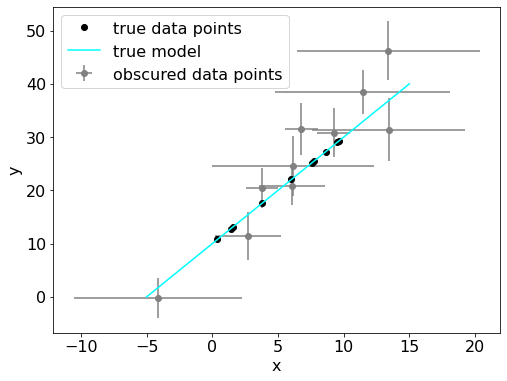

In [8]:
plt.plot(x_latent,y_true,'o',label='true data points')
plt.errorbar(x_obs,y_obs,
             xerr=sigma_x,yerr=sigma_y,
             marker='o',color='gray',linestyle='',label='obscured data points')
plt.plot(x_model,a+b*x_model,'-',color='cyan',label='true model')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

<h3>Now, the likelihood, $\mathscr{L}(D|M)$, comes into play, defining how probable it is to measure a data point $y_i$ (under its associated uncertainty $\sigma_{y,i}$), given the model $f(\hat{x}_i;a,b)$:<br>
    $\mathscr{L}(D|M) = \mathscr{L}(a,b) = \prod_{i=0}^{N_{obs}-1} \frac{1}{\sqrt{2\pi}\sigma_{y,i}}\exp\left(-\frac{(y_i - f(\hat{x}_i;a,b))^2}{2\sigma_{y,i}^2}\right)$ with $\hat{x}_i \sim \mathscr{N}(x_i,\sigma_{x,i})$<br>
    This is the likelihood for normally distributed data ($\chi^2$-case).</h3>

<h3>Each parameter in a model can (and often should) have a prior associated with it.<br><br>
    In the Stan model fit_xy.stan, no priors are defined, and $a$ and $b$ are determined without priors. In fit_xy_with_priors.stan, priors on $a$ and $b$ are defined as normal distributions, such that<br>
    $P(a) = \frac{1}{\sqrt{2\pi}\sigma_a}\exp\left(-\frac{(\mu_a - a)^2}{2\sigma_a^2}\right)$ and <br>
    $P(b) = \frac{1}{\sqrt{2\pi}\sigma_b}\exp\left(-\frac{(\mu_b - b)^2}{2\sigma_b^2}\right)$, with<br>
    our belief in $a$ to be distributed around a value $\mu_a$ with width $\sigma_a$, and $b$ around $\mu_b$ with width $\sigma_b$.</h3>

<h3>Bayes' law tells us, how to put these things together:<br>
    $P(M|D) = \frac{P(D|M)P(M)}{P(D)}$, from which we can identify our distributions, an write<br>
    $\pi(a,b) \propto \mathscr{L}(a,b)P(a)P(b)$, where the priors for $a$ and $b$ are taken independently, where the density function of interest $\pi(a,b)$ is the joint posterior probability of $a$ and $b$.</h3>

<h3>Step 3:<br>
    Define a model</h3>

<h5>We compile the models using the pystan interface as:</h5>

In [9]:
try:
    #read filename.pkl (if already compiled)
    model = pickle.load(open('fit_xy.pkl', 'rb'))

except:
    print('Model not yet compiled, doing that now (might take a minute).')
    ## compile model (if not yet compiled):
    model = pystan.StanModel('fit_xy.stan')

    ## save it to the file 'fit_xy.pkl' for later use
    with open('fit_xy.pkl', 'wb') as f:
        pickle.dump(model, f)

<h5>The Stan model looks like this:</h5>

In [10]:
print(model.show())

StanModel object 'anon_model_5133cae6a115e0ceb58a605620472590' coded as follows:
data {

  int<lower=0> N;             // number of data points
  vector[N] x_obs;            // x observations
  vector[N] y_obs;            // y observations  
  vector<lower=0>[N] sigma_x; // measurement uncertainty in x
  vector<lower=0>[N] sigma_y; // measurement uncertainty in y

  
  int<lower=0> N_model;       // number of point to evaluate the fitted model
  vector[N_model] x_model;    // where to evaluate the model (for plotting)

  // priors on the fitted parameters
  // (can be very broad to avoid bias)
  // real mu_a;
  // real sigma_a;
  // real mu_b;
  // real sigma_b;

}

parameters {
  
  real a;  // y intercept
  real b;  // slope
  vector[N] x_latent;  // latent x location (x_obs + randomn(sigma_x))
  
}


transformed parameters {

  // latent y values, not obscured by measurement error
  // (the model or correlation you are fitting for)
  vector[N] y_true = a + b*x_latent;

}


model {



<h5>Here, the data block is what is provided to Stan through a python dictionary (see below).<br>
    If you want to use priors, you need to compile the other stan model fit_xy_with_priors.stan, and include the priors in the dictioray as well.</h5>

<h5>Following the data block, we also need the variables $N_{model}$ and $x_{model}$, which is the number of data points and where we want to evaluate our fitted model. These are the points where we want to make a 'prediction', given the data, its uncertainties, the model definition (and the priors of the model parameters).</h5>

In [11]:
# where to evaluate the model
N_model = 100
x_model = np.linspace(-10,25,N_model)

<h5>Finally, our data block is given by the following dictionary:</h5>

In [12]:
# dictionary for data set and prior
data = dict(N = N_obs,
            x_obs = x_obs,
            y_obs = y_obs,
            sigma_x = sigma_x,
            sigma_y = sigma_y,
            N_model = N_model,
            x_model = x_model)

<h3>Step 4:<br>
    Fit the data</h3>

<h5>And then, fit:</h5>

In [13]:
# fit the model
fit = model.sampling(data=data,chains=1,iter=10000)

<h5>First, we look at our interesting parameters $a$ and $b$ that we got from the fit:</h5>

In [14]:
print(fit.stansummary(['a','b']))

Inference for Stan model: anon_model_5133cae6a115e0ceb58a605620472590.
1 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=5000.

    mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a  12.73    0.12   3.86   4.01  10.69   13.2  15.27  18.91   1064    1.0
b    1.9    0.02   0.53   1.13   1.53   1.82   2.16    3.1    853    1.0

Samples were drawn using NUTS at Thu Jul 15 13:09:31 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


<h5>Here, we see the mean an std of $a$ and $b$ which we can quote as the results of our fits, and would be done.<br>
    However, we have to assess the fit itself, for which we extract the different samples, look at their distributions, visualise our model, and make predictions.</h5>

<h5>First, a plot of the marginalised posterior distributions of $a$ and $b$, i.e.<br>
   $\pi(a) = \int_{-\infty}^{+\infty} db\,\pi(a,b)$ and $\pi(b) = \int_{-\infty}^{+\infty} da\,\pi(a,b)$

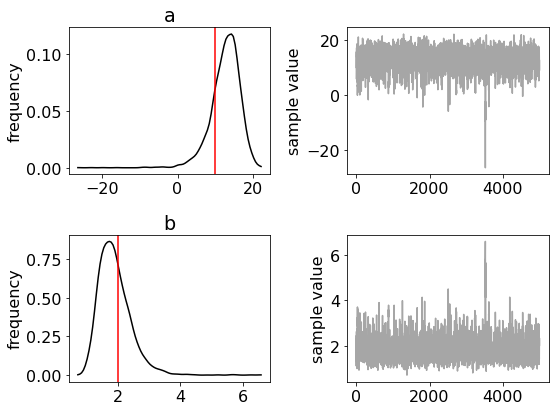

In [15]:
# stan plot
fig = fit.plot(['a','b'],)

# true values
fig.axes[0].axvline(a,color='red')
fig.axes[2].axvline(b,color='red')

plt.tight_layout()

<h5>Extract the parameter chains and other generated quantities from the fitted Stan model:</h5>

In [16]:
# extract information
chain = fit.extract()

In [17]:
chain.keys() # what's inside:
# distributions of a and b and the generated quantities from the Stan model

odict_keys(['a', 'b', 'x_latent', 'y_true', 'ppc_x', 'ppc_y', 'line', 'lp__'])

<h3>Step 5:<br>
    Assess the fit quality</h3>

<h5>Now, we plot the model prediction on top of our data points, and compare the fit visually:</h5>

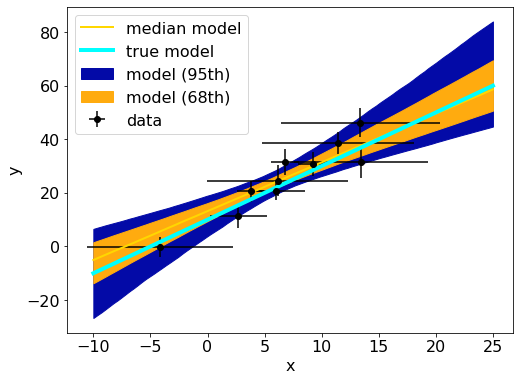

In [18]:
plt.errorbar(x_obs,y_obs,xerr=sigma_x,yerr=sigma_y,marker='o',linestyle='',color='black',label='data')

level = 95.4
plt.fill_between(x_model,
                np.percentile(chain['line'], 50 - 0.5*level, axis=0 ),
                np.percentile(chain['line'], 50 + 0.5*level, axis=0 ),
                color='xkcd:cobalt blue',alpha=1.0,label='model (95th)')

level = 68.3
plt.fill_between(x_model,
                np.percentile(chain['line'], 50 - 0.5*level, axis=0 ),
                np.percentile(chain['line'], 50 + 0.5*level, axis=0 ),
                color='xkcd:yellowish orange',alpha=1,label='model (68th)')

fit_model = np.median(chain['line'],axis=0)
plt.plot(x_model,fit_model,linewidth=2,color='gold',label='median model')
    
plt.xlabel('x')
plt.ylabel('y')

plt.plot(x_model,a+x_model*b,color='cyan',linewidth=4,label='true model')

plt.legend()

<h5>The cyan line of our true model (input which we defined to create the data in the first place), should be within the blue band most of the time.<br>
    We see that the model gets more uncertain when we go beyond our first and last data points, which is clear as nothing constrains the fit there.</h5>

<h5>Alternative, we can also plot individual realisations of our posterior model to see underlying structure (if any; not here):</h5>

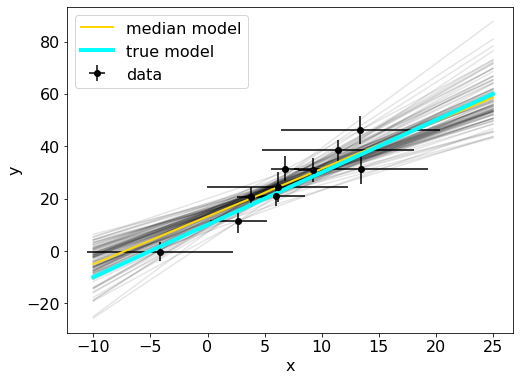

In [19]:
plt.errorbar(x_obs,y_obs,xerr=sigma_x,yerr=sigma_y,marker='o',linestyle='',color='black',label='data')
for i in range(0,1000,10):
    plt.plot(x_model,chain['line'][i,:],alpha=0.1,color='black')
plt.plot(x_model,fit_model,linewidth=2,color='gold',label='median model')
plt.xlabel('x')
plt.ylabel('y')

plt.plot(x_model,a+x_model*b,color='cyan',linewidth=4,label='true model')

plt.legend()

<h5>As we see in this example, $a$ and $b$ appear anti-correlated: we should also see this in the join posterior distribution $pi(a,b)$ from plotting it in a corner (or triangle) plot:</h5>

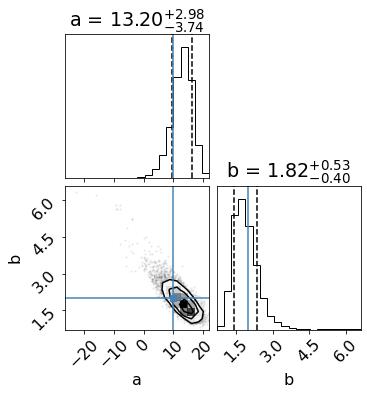

In [20]:
corner.corner(np.array([chain['a'],chain['b']]).T,
              labels=['a','b'],
              quantiles=[0.5-0.683/2,0.5+0.683/2],
              show_titles=True,
              truths=[a,b]);

<h5>We see that the larger $a$, the small (more negative) $b$ should get, and vice versa. This is in the nature of the model, and how the data are actually structured.</h5>

<h5>Finally, we want to know, how good our model would be in predicting new data, i.e. did we find the (or a) good model description that does not only describe the current data set, but also captures the (true) data generating process.<br>
    For this, we perform posterior predictive checks (PPC), that is sampling 'new data' $\tilde{y}$ from our posterior distribution $\pi(a,b|y)$, given our measurement principle, which is incorporated in the likelihood $\mathscr{L}(\tilde{y}|a,b)$, such that<br>
    $\pi(\tilde{y}|y) = \int \int da\,db\,\mathscr{L}(\tilde{y}|a,b) \pi(a,b|y)$.</h5>

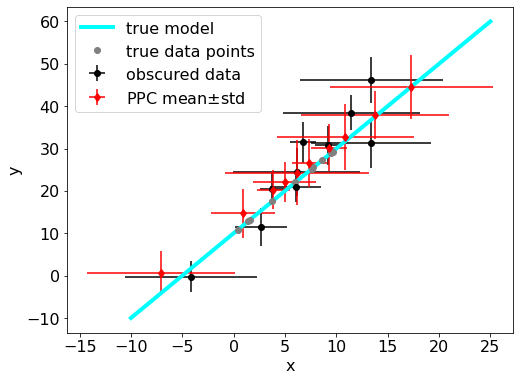

In [21]:
# ppc plot

plt.errorbar(x_obs,y_obs,xerr=sigma_x,yerr=sigma_y,marker='o',linestyle='',color='black',label='obscured data')

plt.errorbar(np.mean(chain['ppc_x'],axis=0),np.mean(chain['ppc_y'],axis=0),
             xerr=np.std(chain['ppc_x'],axis=0),yerr=np.std(chain['ppc_y'],axis=0),
             color='red',marker='d',linestyle='',label=r'PPC mean$\pm$std')

plt.plot(x_model,a+x_model*b,color='cyan',linewidth=4,label='true model')

plt.plot(x_latent,y_true,'o',color='gray',label='true data points')

plt.xlabel('x')
plt.ylabel('y')

plt.legend()

<h5>Crowded plot:<br>
    The true data points are not available to a general data set case, so I just plot them for comparison.<br>
    We do see that the red (replicated) data points do capture the data generating process, even though there seems to be a different trend. Depending on the actual data set realisation, note that the 'error bars' of the replicated data are larger than the those of the obscured (measured) data points themselves. That means, the range of possible data points in a renewed measurement, if our inference was correct, can actually larger than what we see. This makes sense, because PPCs use both the likelihood and posterior information, and takes all(!) values of $a$ and $b$ into account.</h5>

In [22]:
np.std(chain['ppc_y'],axis=0)/sigma_y

array([1.32569106, 1.35224883, 1.20676586, 1.29421567, 1.36184538,
       1.31343408, 1.39404039, 1.38933139, 1.20742463, 1.16139194])

In [23]:
np.std(chain['ppc_x'],axis=0)/sigma_x

array([1.22544066, 1.13299075, 1.35391325, 1.2410905 , 1.14202501,
       1.13660003, 1.12366032, 1.07835538, 1.34025235, 1.33823532])

<h5>And finally, because of the latent variables, we can even look at each data points individually, and check how far away it is from the true(!) value. Might not be too useful when the number of data points is very large:</h3>

<h5>x-values:</h5>

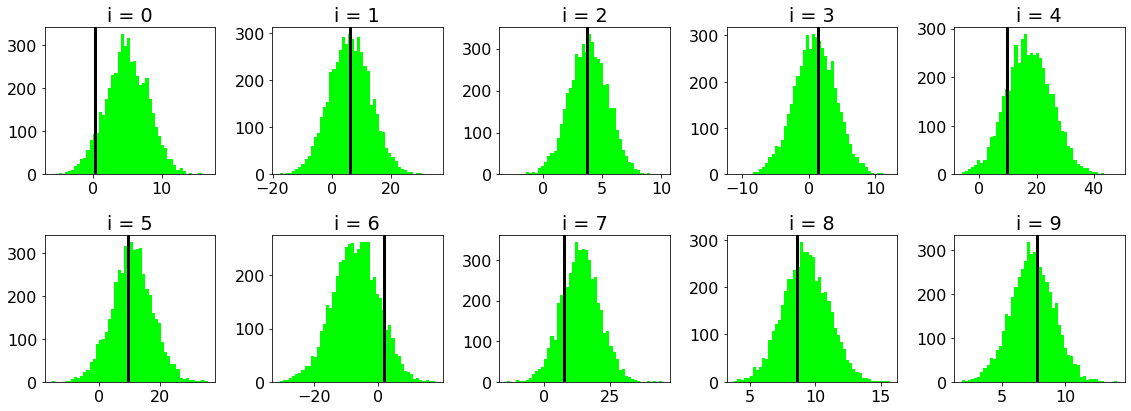

In [24]:
fig, ax = plt.subplots(ncols=5,nrows=2,figsize=(16,6))

for i in range(N_obs):

    axi = ax.ravel()[i]
    axi.hist(chain['ppc_x'][:,i],bins=50,color='lime');
    axi.axvline(x_latent[i],color='black',linewidth=3)
    axi.set_title('i = {}'.format(i))
    
plt.tight_layout()

<h5>y-values:</h5>

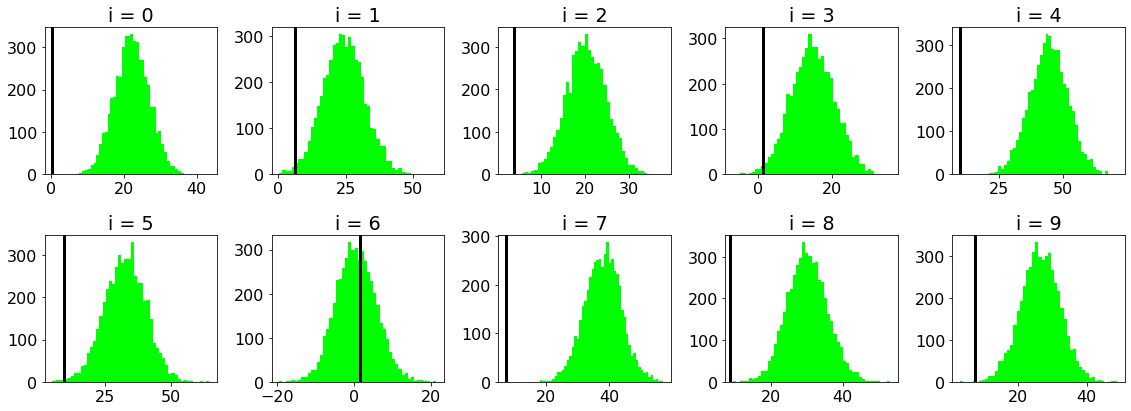

In [25]:
fig, ax = plt.subplots(ncols=5,nrows=2,figsize=(16,6))

for i in range(N_obs):

    axi = ax.ravel()[i]
    axi.hist(chain['ppc_y'][:,i],bins=50,color='lime');
    axi.axvline(x_latent[i],color='black',linewidth=3)
    axi.set_title('i = {}'.format(i))
    
plt.tight_layout()

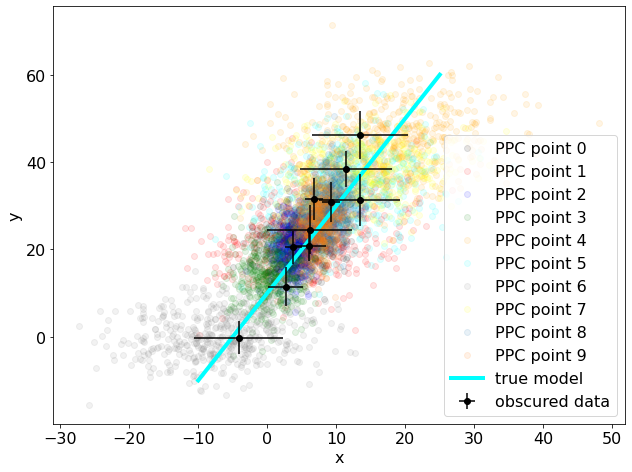

In [38]:
# ppc plot
plt.figure(figsize=(10.24,7.68))

plt.errorbar(x_obs,y_obs,xerr=sigma_x,yerr=sigma_y,marker='o',linestyle='',color='black',label='obscured data',zorder=100)

for i in range(N_obs):
    plt.plot(chain['ppc_x'][::10,i],chain['ppc_y'][::10,i],
             marker='o',alpha=0.1,linestyle='',label='PPC point {0}'.format(i))

plt.plot(x_model,a+x_model*b,color='cyan',linewidth=4,label='true model')

plt.xlabel('x')
plt.ylabel('y')

plt.legend()